In [ ]:
import numpy as np
import librosa
import os
import glob
import tensorflow as tf
from typing import List, Tuple, Optional
from numpy import ndarray
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [2]:
import numpy as np

DATA_DIR: str = "data"
TEST_SET_FILENAME = 'X_test_y_test_features.npz'
MODEL_FILENAME = 'cnn_speech_commands.h5'
MAX_AUDIO_LENGTH = 17000
FRAME_SIZE = 512
HOP_LENGTH = 256
N_MELS = 64
MAX_PAD_LEN = 67 
SR_DEFAULT = 16000
SNR_LEVELS = [20.0, 10.0, 0.0, -5.0] 

AUDIO = 'data/marvin/1a073312_nohash_0.wav'
WGN_FILE = 'white_noise.wav'
BG_NOISE_FILE = 'doing_the_dishes.wav'

try:
    data_all = np.load("processed_data.npz", allow_pickle=True)
    MAX_ABS_VAL = np.abs(data_all['X']).max()
    LABEL_NAMES = data_all['label_names']
    LABEL_MAP = {word: i for i, word in enumerate(LABEL_NAMES)}
except Exception as e:
    print(f"Error loading original features for normalization constant: {e}")
    MAX_ABS_VAL = 1.0 
    LABEL_MAP = {}


In [12]:
def get_log_mel_spec(y: ndarray, sr: int) -> ndarray:
    if len(y) < MAX_AUDIO_LENGTH:
        pad_needed = MAX_AUDIO_LENGTH - len(y)
        pad_start = pad_needed // 2
        pad_end = pad_needed - pad_start
        y_proc = np.pad(y, (pad_start, pad_end), 'constant')
    elif len(y) > MAX_AUDIO_LENGTH:
        y_proc = y[:MAX_AUDIO_LENGTH]
    else:
        y_proc = y
        
    frames = librosa.util.frame(y_proc, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH).T
    window = np.hamming(FRAME_SIZE)
    windowed_frames = frames * window
    stft_frames = np.fft.rfft(windowed_frames)
    power_spectrum = np.abs(stft_frames) ** 2
    mel_filterbank = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=N_MELS)
    mel_spectrum = np.dot(mel_filterbank, power_spectrum.T)
    eps = np.finfo(float).eps
    log_mel_spectrum = 10 * np.log10(mel_spectrum + eps)
    
    if log_mel_spectrum.shape[1] > MAX_PAD_LEN:
        log_mel_spectrum = log_mel_spectrum[:, :MAX_PAD_LEN]
    elif log_mel_spectrum.shape[1] < MAX_PAD_LEN:
        pad_width = MAX_PAD_LEN - log_mel_spectrum.shape[1]
        log_mel_spectrum = np.pad(log_mel_spectrum, ((0, 0), (0, pad_width)), mode='constant')
        
    return log_mel_spectrum

def normalize_and_reshape(log_mel_spec: ndarray, max_val: float) -> ndarray:
    X_norm = log_mel_spec / max_val
    return X_norm[..., np.newaxis]

def mix_audio(clean_y: ndarray, noise_y: ndarray, snr_db: float) -> ndarray:
    """Mixes clean audio and noise at a specific SNR (dB)."""
    
    if len(noise_y) < len(clean_y):
        repeat_factor = int(np.ceil(len(clean_y) / len(noise_y)))
        noise_y = np.tile(noise_y, repeat_factor)[:len(clean_y)]
    
    start = np.random.randint(0, len(noise_y) - len(clean_y) + 1)
    noise_y_segment = noise_y[start:start + len(clean_y)]

    clean_power = np.mean(clean_y**2)
    
    snr_linear = 10**(snr_db / 10.0)
    noise_power_target = clean_power / snr_linear
    
    noise_power_current = np.mean(noise_y_segment**2)
    
    if noise_power_current == 0:
        noise_power_current = np.finfo(float).eps
    
    noise_scale = np.sqrt(noise_power_target / noise_power_current)
    scaled_noise = noise_y_segment * noise_scale
    
    return clean_y + scaled_noise

def load_specific_noise(noise_file_name: str) -> Optional[ndarray] | None:
    """Loads a specific noise file from the background noise directory."""
    noise_path = os.path.join(DATA_DIR, "_background_noise_", noise_file_name)
    if os.path.exists(noise_path):
        y_noise, _ = librosa.load(noise_path, sr=SR_DEFAULT)
        print(f"Successfully loaded specific noise file: {noise_file_name}")
        return y_noise.astype(np.float32)
    else:
        print(f"Warning: Specific noise file not found at {noise_path}")
        return None

def evaluate_model_on_noise(model: tf.keras.Model, noise_type: str, snr_levels: List[float], noise_source_y: Optional[ndarray]) -> tuple[dict, dict]:
    
    if noise_source_y is None:
        print(f"Skipping evaluation for {noise_type} due to missing source file.")
        return {}, {}

    test_data = np.load(TEST_SET_FILENAME, allow_pickle=True)
    X_test_features = test_data['X_test']
    y_test_int = test_data['y_test_int']
    
    # --- Dictionaries to store results ---
    accuracy_results = {}
    prediction_results = {}
    
    # --- Map Test Samples to Raw Audio Files ---
    clean_test_files = []
    word_list = list(LABEL_MAP.keys())
    file_pool = {word: glob.glob(os.path.join(DATA_DIR, word, '*.wav')) for word in word_list}
    
    for i, label_int in enumerate(y_test_int):
        word = word_list[label_int]
        available_files = file_pool[word]
        file_index = i % len(available_files)
        clean_test_files.append(available_files[file_index])
    
    print(f"\n--- Evaluating with {noise_type} on {len(X_test_features)} samples ---")
    
    # Noise Injection and Prediction 
    for snr in snr_levels:
        correct_predictions = 0
        current_snr_predictions = []
        
        for i in range(len(X_test_features)):
            file_path = clean_test_files[i]
            true_label_int = y_test_int[i]
            
            # 1. Load clean audio
            clean_y, sr = librosa.load(file_path, sr=SR_DEFAULT)
            
            # 2. Mix audio
            noisy_y = mix_audio(clean_y, noise_source_y, snr)
            
            # 3. Extract noisy feature
            noisy_spec = get_log_mel_spec(noisy_y, sr)
            
            # 4. Normalize and Reshape
            X_noisy = normalize_and_reshape(noisy_spec, MAX_ABS_VAL)
            
            # 5. Predict
            X_noisy_batch = np.expand_dims(X_noisy, axis=0)
            prediction = model.predict(X_noisy_batch, verbose=0)
            predicted_class = np.argmax(prediction)
            
            current_snr_predictions.append(predicted_class)
            
            if predicted_class == true_label_int:
                correct_predictions += 1
                
        accuracy = correct_predictions / len(X_test_features)
        accuracy_results[snr] = accuracy
        prediction_results[snr] = current_snr_predictions
        
        print(f"  SNR {snr:4.1f} dB Accuracy: {accuracy:.4f}")

    return accuracy_results, prediction_results

    """Re-usable helper to get spec from a raw signal (assuming y_proc is MAX_AUDIO_LENGTH)."""
    
    # 3. Frame the signal
    frames = librosa.util.frame(y_proc, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH).T 

    # 4. Apply window
    window = np.hamming(FRAME_SIZE)
    windowed_frames = frames * window

    # 5. Compute the magnitude power spectrum
    stft_frames = np.fft.rfft(windowed_frames)
    power_spectrum = np.abs(stft_frames) ** 2

    # 6. Apply mel filterbank
    mel_filterbank = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=N_MELS)
    mel_spectrum = np.dot(mel_filterbank, power_spectrum.T)

    # 7. Convert to log scale (dB)
    eps = np.finfo(float).eps
    log_mel_spectrum = 10 * np.log10(mel_spectrum + eps)
    
    return log_mel_spectrum


Successfully loaded specific noise file: white_noise.wav
Successfully loaded specific noise file: doing_the_dishes.wav


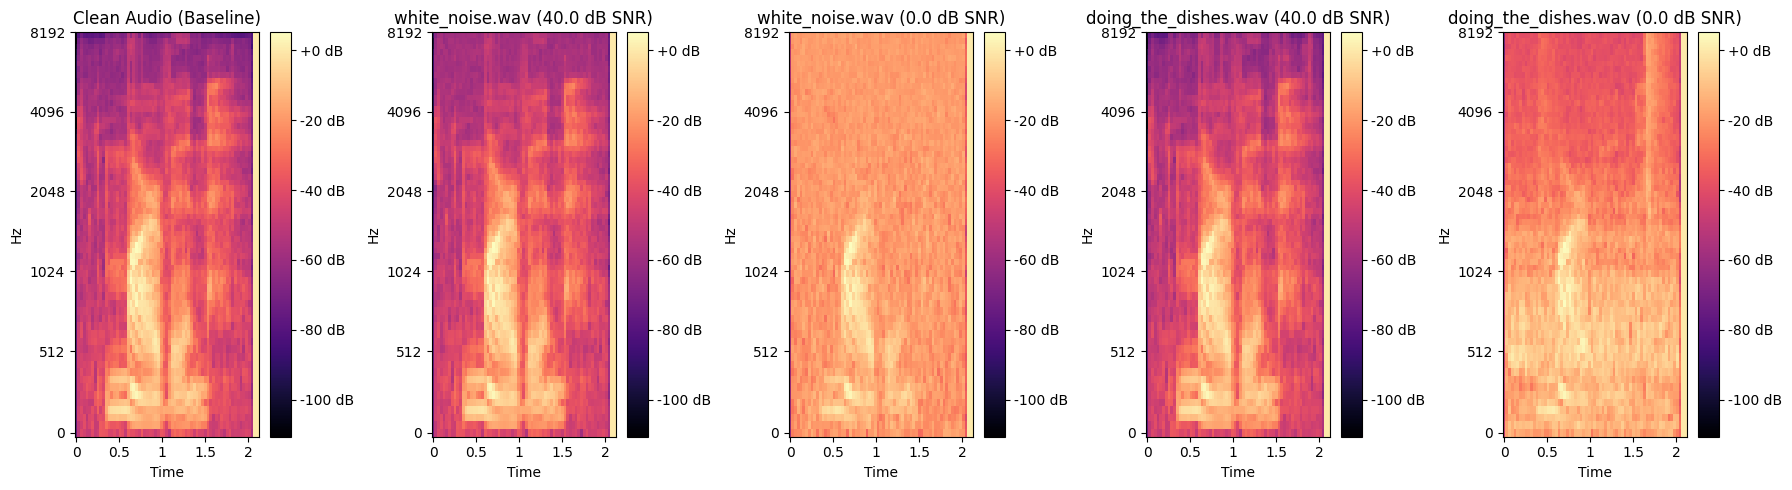

In [13]:
def visualize_noise_effects():
    # 1. Load Noise Sources
    wgn_source_y = load_specific_noise(WGN_FILE)
    bg_noise_source_y = load_specific_noise(BG_NOISE_FILE)
    
    if wgn_source_y is None or bg_noise_source_y is None:
        print("Error: Could not load one or both noise source files.")
        return

    # 2. Select a single clean audio file (e.g., the first 'marvin' sample)
    clean_audio_path = glob.glob(os.path.join(DATA_DIR, 'marvin', '*.wav'))[0]
    y_clean, sr = librosa.load(clean_audio_path, sr=SR_DEFAULT)
    
    # 3. Create Spectrograms
    spec_clean = get_log_mel_spec(y_clean, sr)
    
    # WGN
    y_wgn_40 = mix_audio(y_clean, wgn_source_y, 40.0)
    spec_wgn_40 = get_log_mel_spec(y_wgn_40, sr)
    y_wgn_0 = mix_audio(y_clean, wgn_source_y, 0.0)
    spec_wgn_0 = get_log_mel_spec(y_wgn_0, sr)

    # Background Noise (Dishes)
    y_bg_40 = mix_audio(y_clean, bg_noise_source_y, 40.0)
    spec_bg_40 = get_log_mel_spec(y_bg_40, sr)
    y_bg_0 = mix_audio(y_clean, bg_noise_source_y, 0.0)
    spec_bg_0 = get_log_mel_spec(y_bg_0, sr)

    # 4. Plotting
    fig, axes = plt.subplots(1, 5, figsize=(18, 5))
    
    # Common color bar settings (max/min log-mel value across all generated specs)
    vmax = max(spec_clean.max(), spec_wgn_40.max(), spec_wgn_0.max(), spec_bg_40.max(), spec_bg_0.max())
    vmin = min(spec_clean.min(), spec_wgn_40.min(), spec_wgn_0.min(), spec_bg_40.min(), spec_bg_0.min())

    # Helper for plotting
    def plot_spec(ax, spec, title):
        librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='mel', ax=ax, cmap='magma', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        fig.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB')

    plot_spec(axes[0], spec_clean, 'Clean Audio (Baseline)')
    plot_spec(axes[1], spec_wgn_40, f'{WGN_FILE} (40.0 dB SNR)')
    plot_spec(axes[2], spec_wgn_0, f'{WGN_FILE} (0.0 dB SNR)')
    plot_spec(axes[3], spec_bg_40, f'{BG_NOISE_FILE} (40.0 dB SNR)')
    plot_spec(axes[4], spec_bg_0, f'{BG_NOISE_FILE} (0.0 dB SNR)')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    visualize_noise_effects()


In [5]:
def extract_log_mel_spectrogram_manual(file_path: str) -> Tuple[Optional[ndarray], Optional[ndarray], Optional[float]]:
    sr: float = SR_DEFAULT
    try:
        y, sr = librosa.load(file_path, sr=SR_DEFAULT) 

        if len(y) < MAX_AUDIO_LENGTH:
            pad_needed = MAX_AUDIO_LENGTH - len(y)
            pad_start = pad_needed // 2
            pad_end = pad_needed - pad_start
            y_proc = np.pad(y, (pad_start, pad_end), 'constant')
        elif len(y) > MAX_AUDIO_LENGTH:
            y_proc = y[:MAX_AUDIO_LENGTH]
        else:
            y_proc = y

        frames = librosa.util.frame(y_proc, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH).T 
        window = np.hamming(FRAME_SIZE)
        windowed_frames = frames * window
        stft_frames = np.fft.rfft(windowed_frames)
        power_spectrum = np.abs(stft_frames) ** 2
        mel_filterbank = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=N_MELS)
        mel_spectrum = np.dot(mel_filterbank, power_spectrum.T)
        eps = np.finfo(float).eps
        log_mel_spectrum = 10 * np.log10(mel_spectrum + eps)

        return log_mel_spectrum, y_proc, sr
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None

def generate_spec_from_signal(y_proc: ndarray, sr: float) -> Optional[ndarray]:
    """Re-usable helper to get spec from a raw signal (assuming y_proc is MAX_AUDIO_LENGTH)."""
    
    # 3. Frame the signal
    frames = librosa.util.frame(y_proc, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH).T 

    # 4. Apply window
    window = np.hamming(FRAME_SIZE)
    windowed_frames = frames * window

    # 5. Compute the magnitude power spectrum
    stft_frames = np.fft.rfft(windowed_frames)
    power_spectrum = np.abs(stft_frames) ** 2

    # 6. Apply mel filterbank
    mel_filterbank = librosa.filters.mel(sr=sr, n_fft=FRAME_SIZE, n_mels=N_MELS)
    mel_spectrum = np.dot(mel_filterbank, power_spectrum.T)

    # 7. Convert to log scale (dB)
    eps = np.finfo(float).eps
    log_mel_spectrum = 10 * np.log10(mel_spectrum + eps)
    
    return log_mel_spectrum

def add_white_gaussian_noise(signal: np.ndarray, snr_db: float) -> np.ndarray:
    """Adds WGN to a signal at a specified SNR."""
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    
    noise = np.random.normal(0, noise_std, signal.shape)
    return signal + noise

def add_background_noise(signal: np.ndarray, noise_path: str, sr: float, snr_db: float) -> np.ndarray:
    """Loads a real noise file, aligns, scales, and mixes it with the signal."""
    
    y_noise_raw, _ = librosa.load(noise_path, sr=sr)
    
    if len(y_noise_raw) < len(signal):
        tile_factor = int(np.ceil(len(signal) / len(y_noise_raw)))
        y_noise_aligned = np.tile(y_noise_raw, tile_factor)[:len(signal)]
    else:
        start_idx = np.random.randint(0, len(y_noise_raw) - len(signal) + 1)
        y_noise_aligned = y_noise_raw[start_idx : start_idx + len(signal)]

    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10.0)
    target_noise_power = signal_power / snr_linear

    current_noise_power = np.mean(y_noise_aligned**2)
    scale_factor = np.sqrt(target_noise_power / current_noise_power)
    y_noise_scaled = y_noise_aligned * scale_factor
    
    return signal + y_noise_scaled


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(ax, y_true, y_pred, title):
    """Helper function to plot a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    # Normalize by row (true label) to show percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, cbar=False)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

Starting Noise Robustness Evaluation & Confusion Matrix Generation...
Successfully loaded model: cnn_speech_commands.h5
Successfully loaded specific noise file: white_noise.wav
Successfully loaded specific noise file: doing_the_dishes.wav

--- Evaluating with White Gaussian Noise on 200 samples ---
  SNR 20.0 dB Accuracy: 0.7400
  SNR 10.0 dB Accuracy: 0.5400
  SNR  0.0 dB Accuracy: 0.2250
  SNR -5.0 dB Accuracy: 0.1300

--- Evaluating with Background Noise (Dishes) on 200 samples ---
  SNR 20.0 dB Accuracy: 0.6650
  SNR 10.0 dB Accuracy: 0.4450
  SNR  0.0 dB Accuracy: 0.2600
  SNR -5.0 dB Accuracy: 0.1650


--- Final Noise Robustness Summary ---
Condition                      | Accuracy (%)   
-----------------------------------------------
Clean Audio                    | 77.00%
-----------------------------------------------
White Gaussian Noise @ 20.0 dB | 74.00%
White Gaussian Noise @ 10.0 dB | 54.00%
White Gaussian Noise @  0.0 dB | 22.50%
White Gaussian Noise @ -5.0 dB | 13.00%


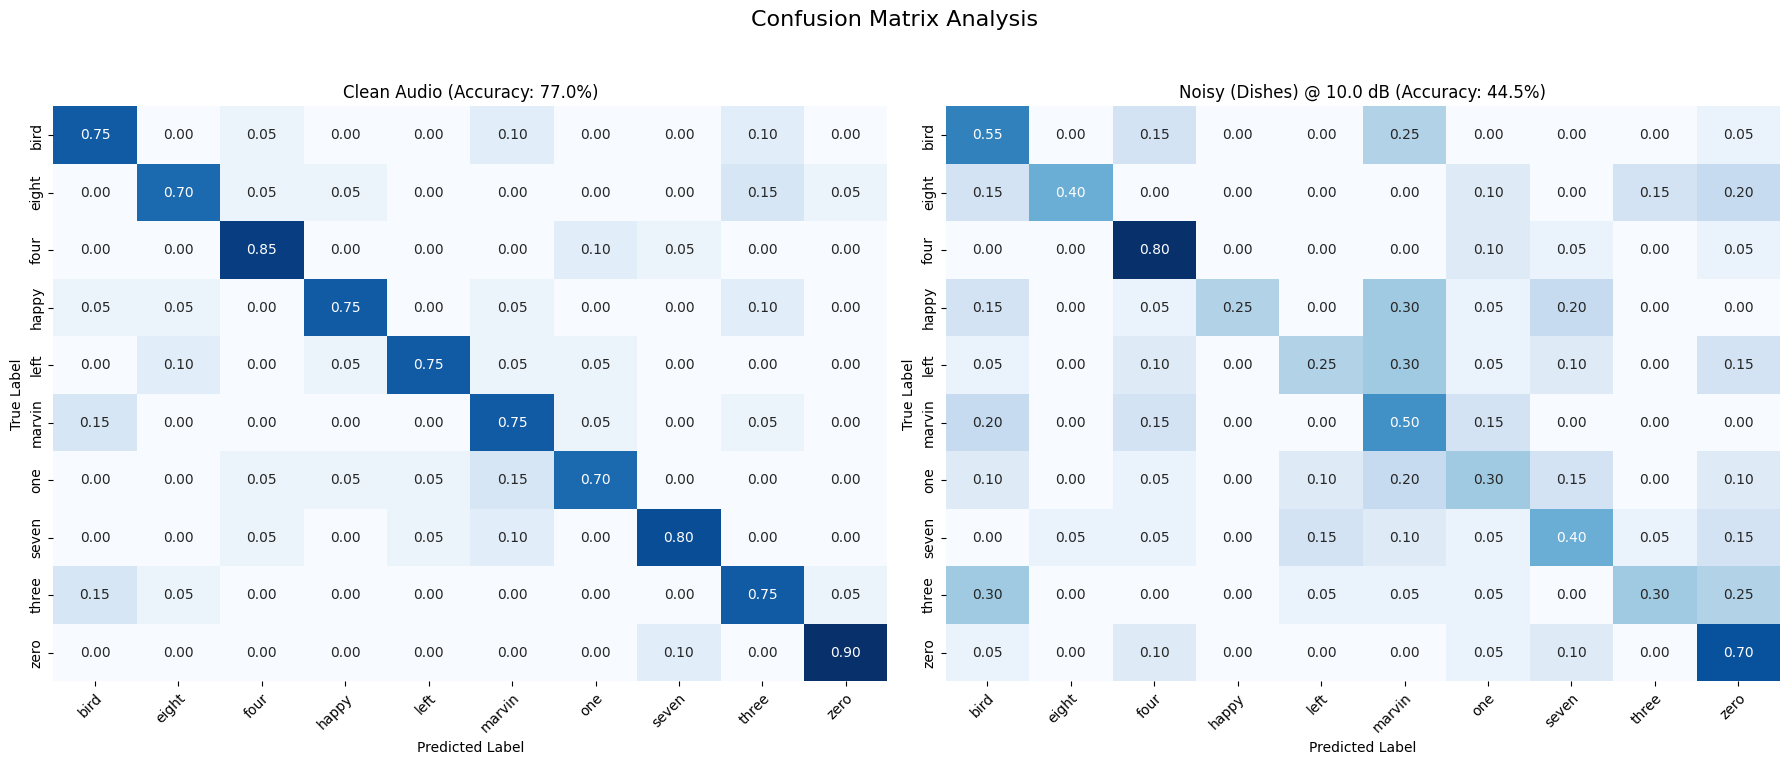

In [15]:
if __name__ == '__main__':
    
    print("Starting Noise Robustness Evaluation & Confusion Matrix Generation...")

    # 1. Load Model
    try:
        model = load_model(MODEL_FILENAME, compile=False) 
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(f"Successfully loaded model: {MODEL_FILENAME}")
    except Exception as e:
        print(f"Error loading model: {e}")
        exit()

    # 2. Load Specific Noise Data Files
    WGN_SOURCE_Y = load_specific_noise(WGN_FILE)
    BG_NOISE_SOURCE_Y = load_specific_noise(BG_NOISE_FILE)

    # 3. Evaluate with WGN (Capture accuracies and predictions)
    wgn_results, wgn_predictions = evaluate_model_on_noise(
        model, 'White Gaussian Noise', SNR_LEVELS, WGN_SOURCE_Y
    )

    # 4. Evaluate with Background Noise (Capture accuracies and predictions)
    bg_results, bg_predictions = evaluate_model_on_noise(
        model, 'Background Noise (Dishes)', SNR_LEVELS, BG_NOISE_SOURCE_Y
    )

    # 5. Generate Final Summary Table
    print("\n\n--- Final Noise Robustness Summary ---")
    
    test_data = np.load(TEST_SET_FILENAME, allow_pickle=True)
    X_test_clean = test_data['X_test']
    y_test_clean = test_data['y_test']
    y_true_int = test_data['y_test_int'] # Get the true integer labels

    _, clean_accuracy = model.evaluate(X_test_clean, y_test_clean, verbose=0)
    
    print(f"{'Condition':<30} | {'Accuracy (%)':<15}")
    print("-" * 47)
    print(f"{'Clean Audio':<30} | {clean_accuracy * 100:.2f}%")
    print("-" * 47)

    for snr in SNR_LEVELS:
        wgn_acc = wgn_results.get(snr, np.nan)
        print(f"White Gaussian Noise @ {snr:4.1f} dB | {wgn_acc * 100:.2f}%")
    print("-" * 47)

    if bg_results:
        for snr in SNR_LEVELS:
            bg_acc = bg_results.get(snr, np.nan)
            print(f"Background Noise (Dishes) @ {snr:4.1f} dB | {bg_acc * 100:.2f}%")
            
    # --- 6. NEW: Generate and Plot Confusion Matrices ---
    print("\n--- Generating Confusion Matrices ---")
    
    # 6a. Get Clean Predictions
    print("Generating predictions for CLEAN data...")
    y_pred_clean_probs = model.predict(X_test_clean, verbose=0)
    y_pred_clean_int = np.argmax(y_pred_clean_probs, axis=1)
    
    # 6b. Get Noisy Predictions (Select 10.0 dB Background Noise)
    # We check if the key exists in case the evaluation was skipped
    if 10.0 in bg_predictions:
        y_pred_noisy_int = bg_predictions[10.0]
        noisy_accuracy = np.mean(y_true_int == y_pred_noisy_int) * 100
        
        # 6c. Plot
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
        plot_confusion_matrix(axes[0], y_true_int, y_pred_clean_int, 
                              f'Clean Audio (Accuracy: {clean_accuracy*100:.1f}%)')
        
        plot_confusion_matrix(axes[1], y_true_int, y_pred_noisy_int, 
                              f'Noisy (Dishes) @ 10.0 dB (Accuracy: {noisy_accuracy:.1f}%)')
        
        fig.suptitle('Confusion Matrix Analysis', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('confusion_matrix_comparison.png')
        print("✅ Confusion matrix plot saved as 'confusion_matrix_comparison.png'")
        plt.show()
    else:
        print("Could not generate noisy confusion matrix: 10.0 dB results not found.")